# Predicting flight delays (exploration)
Pierre-Yves BOISBUNON - May 2018


----------

The target is to rework flight delays prediction based on the dataset **dataset_modele.csv**, the one used for **PROJET 4** (Open Classrooms Project).

In this notebook, we will explore rapidly this dataset and compute our baseline based on previously identified model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Dataset

Let's reopen the dataset previously stored: **dataset_modele.csv**

## 1.1 Import previously stored model

In [2]:
import datetime
df_tmp = pd.read_csv('dataset_modele.csv', sep=',', error_bad_lines=False)

Due to BOX-COX transformation processed on **DISTANCE** and **ARRIVAL_DELAY** variables, let's import BOX-COX constants:

In [3]:
coxbox_ld_distance = 0.15921412370657623
coxbox_ld_arrival_delay = -2.4838584691985517
coxbox_add_arrival_delay = 179

In [4]:
df_tmp.head()

,AIRL_EV,AIRL_B6,AIRL_DL,AIRL_WN,AIRL_OO,AIRL_F9,AIRL_AA,AIRL_UA,AIRL_NK,AIRL_VX,...,SCHEDULED_DEPARTURE_HOUR,SCHEDULED_DEPARTURE_MINUTE,SCHEDULED_DEPARTURE_SECOND,IS_WEEKEND,SCHEDULED_ARRIVAL_HOUR,SCHEDULED_ARRIVAL_MINUTE,SCHEDULED_ARRIVAL_SECONDE,DISTANCE,ARRIVAL_DELAY,SCHEDULED_ELAPSED_TIME
0,1,0,0,0,0,0,0,0,0,0,...,17,35,0,0,18,41,0,8.331490,0.402599,66.0
1,0,1,0,0,0,0,0,0,0,0,...,21,40,0,1,0,36,0,12.805626,0.402599,176.0
2,0,0,0,1,0,0,0,0,0,0,...,21,15,0,0,22,35,0,9.407052,0.402598,80.0
3,0,0,0,0,1,0,0,0,0,0,...,15,19,0,1,16,55,0,9.964518,0.402599,96.0
4,0,0,1,0,0,0,0,0,0,0,...,19,0,0,0,20,40,0,10.650590,0.402598,100.0


In [5]:
# https://stackoverflow.com/questions/26391454/reverse-box-cox-transformation
def invboxcox(y,ld, offset):
    if ld == 0:
        return (np.exp(y) - offset)
    else:
        return (np.exp(np.log(ld*y+1)/ld) - offset)

Let's read different airlines, origine airport and destination airports (each one is prefixed):

In [6]:
airline = [col for col in df_tmp.columns if 'AIRL_' in col ]
origine = [col for col in df_tmp.columns if 'ORIG_' in col ]
destination = [col for col in df_tmp.columns if 'DEST_' in col ]

In [7]:
len(airline)

12

In [8]:
len(origine)

308

In [9]:
len(destination)

307

We can observe that we got scheduled departed month from January to December:

In [10]:
min(df_tmp.SCHEDULED_DEPARTURE_MONTH)

1

In [11]:
max(df_tmp.SCHEDULED_DEPARTURE_MONTH)

12

## 1.2 Variation of delay per month

Let's observe the delay variation per month:

Text(0.5,1,'Flight delay based on month departure')

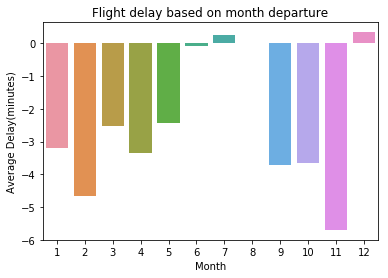

In [12]:
month_list = df_tmp.SCHEDULED_DEPARTURE_MONTH.unique()
month_mean_delay = []

for month in month_list:
    subset = invboxcox(df_tmp[df_tmp.SCHEDULED_DEPARTURE_MONTH == month]["ARRIVAL_DELAY"], coxbox_ld_arrival_delay, coxbox_add_arrival_delay)
    month_mean_delay.append(subset.mean())

my_df = pd.DataFrame({'index': month_list, 'missing_values': month_mean_delay})
my_df = my_df.sort_values('missing_values')

fig, ax = plt.subplots()

sns.barplot(x='index', y="missing_values", data=my_df, ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Average Delay(minutes)')
ax.set_title('Flight delay based on month departure')

In case of timeseries prediction we are looking for a monthly trend flat in several months (we only one year history), let's select March, April and May months.

In [13]:
df_tmp = df_tmp[(df_tmp.SCHEDULED_DEPARTURE_MONTH == 3) | (df_tmp.SCHEDULED_DEPARTURE_MONTH == 4) | (df_tmp.SCHEDULED_DEPARTURE_MONTH == 5)]

## 1.3 Variationnal delay per day

If we look the variationnal delay on day:

Text(0.5,1,'Flights delay based on day departure')

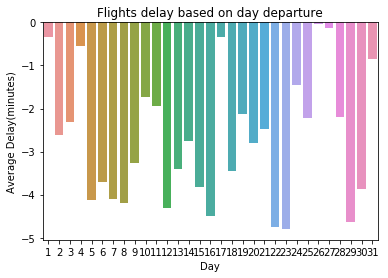

In [14]:
# Let's find ORIGIN_AIRPORT_ID
df_subset = df_tmp

day_list = df_subset.SCHEDULED_DEPARTURE_DAY.unique()
day_mean_delay = []

for day in day_list:
    subset = invboxcox(df_subset[df_subset.SCHEDULED_DEPARTURE_DAY == day]["ARRIVAL_DELAY"], coxbox_ld_arrival_delay, coxbox_add_arrival_delay)
    day_mean_delay.append(subset.mean())

my_df = pd.DataFrame({'index': day_list, 'missing_values': day_mean_delay})
my_df = my_df.sort_values('missing_values')

fig, ax = plt.subplots()

sns.barplot(x='index', y="missing_values", data=my_df, ax=ax)
ax.set_xlabel('Day')
ax.set_ylabel('Average Delay(minutes)')
ax.set_title('Flights delay based on day departure')

We can see that some days have highest delay than other: day 1  vs day 23 for example.

## 1.4. Rebuild dataframe components

In order to keep one column per airline, origin and destination let's gather all AIRLINE, ORIGIN and DESTINATION into only one column:

In [15]:
airline_arr = []
for index, col in df_tmp.iterrows():
    for air in airline:
        if (col[air] == 1):
            airline_arr.append(air)
df_tmp['AIRLINE'] = airline_arr
print('added AIRLINE')

origine_arr = []
for index, col in df_tmp.iterrows():
    for orig in origine:
        if (col[orig] == 1):
            origine_arr.append(orig)
df_tmp['ORIGIN'] = origine_arr

print('added ORIGIN')
destination_arr = []
for index, col in df_tmp.iterrows():
    for dest in destination:
        if (col[dest] == 1):
            destination_arr.append(dest)
df_tmp['DESTINATION'] = destination_arr
print('added DESTINATION')

added AIRLINE
added ORIGIN
added DESTINATION


In [16]:
df_tmp.head()

,AIRL_EV,AIRL_B6,AIRL_DL,AIRL_WN,AIRL_OO,AIRL_F9,AIRL_AA,AIRL_UA,AIRL_NK,AIRL_VX,...,IS_WEEKEND,SCHEDULED_ARRIVAL_HOUR,SCHEDULED_ARRIVAL_MINUTE,SCHEDULED_ARRIVAL_SECONDE,DISTANCE,ARRIVAL_DELAY,SCHEDULED_ELAPSED_TIME,AIRLINE,ORIGIN,DESTINATION
18964,0,0,0,1,0,0,0,0,0,0,...,0,23,15,0,11.904045,0.402599,120.0,AIRL_WN,ORIG_DEN,DEST_SAT
18965,0,0,0,1,0,0,0,0,0,0,...,0,13,0,0,14.695597,0.402599,255.0,AIRL_WN,ORIG_LAX,DEST_ATL
18966,0,0,0,1,0,0,0,0,0,0,...,0,20,50,0,9.621861,0.402598,70.0,AIRL_WN,ORIG_SJC,DEST_SNA
18967,1,0,0,0,0,0,0,0,0,0,...,0,11,11,0,6.412105,0.402598,46.0,AIRL_EV,ORIG_ATL,DEST_CSG
18968,0,0,0,0,0,0,1,0,0,0,...,0,15,26,0,14.385260,0.402599,231.0,AIRL_AA,ORIG_PHX,DEST_CLT


In the same way, let's gather **SCHEDULED_DEPARTURE** and **SCHEDULED_ARRIVAL** columns in the same one:

In [17]:
dt_dep = []
for index, col in df_tmp.iterrows():
    dt_dep.append(pd.to_datetime(datetime.datetime(2016, 
                                                   col['SCHEDULED_DEPARTURE_MONTH'], 
                                                   col['SCHEDULED_DEPARTURE_DAY'], 
                                                   col['SCHEDULED_DEPARTURE_HOUR'], 
                                                   col['SCHEDULED_DEPARTURE_MINUTE'], 
                                                   col['SCHEDULED_DEPARTURE_SECOND'])))
df_tmp['SCHEDULED_DEPARTURE'] = dt_dep

In [18]:
dt_arr = []
for index, col in df_tmp.iterrows():
    dt_arr.append(datetime.time(col['SCHEDULED_ARRIVAL_HOUR'],
                                col['SCHEDULED_ARRIVAL_MINUTE'],
                                col['SCHEDULED_ARRIVAL_SECONDE']))
df_tmp['SCHEDULED_ARRIVAL'] = dt_arr

In [19]:
#df_tmp.iloc[0]

In [20]:
df_tmp.index = pd.to_datetime(df_tmp['SCHEDULED_DEPARTURE'])
#df_tmp.drop('SCHEDULED_DEPARTURE', inplace=True, axis=1)
df_tmp.head()

,AIRL_EV,AIRL_B6,AIRL_DL,AIRL_WN,AIRL_OO,AIRL_F9,AIRL_AA,AIRL_UA,AIRL_NK,AIRL_VX,...,SCHEDULED_ARRIVAL_MINUTE,SCHEDULED_ARRIVAL_SECONDE,DISTANCE,ARRIVAL_DELAY,SCHEDULED_ELAPSED_TIME,AIRLINE,ORIGIN,DESTINATION,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL
SCHEDULED_DEPARTURE,,,,,,,,,,,,,,,,,,,,,
2016-03-29 20:15:00,0,0,0,1,0,0,0,0,0,0,...,15,0,11.904045,0.402599,120.0,AIRL_WN,ORIG_DEN,DEST_SAT,2016-03-29 20:15:00,23:15:00
2016-03-11 05:45:00,0,0,0,1,0,0,0,0,0,0,...,0,0,14.695597,0.402599,255.0,AIRL_WN,ORIG_LAX,DEST_ATL,2016-03-11 05:45:00,13:00:00
2016-03-21 19:40:00,0,0,0,1,0,0,0,0,0,0,...,50,0,9.621861,0.402598,70.0,AIRL_WN,ORIG_SJC,DEST_SNA,2016-03-21 19:40:00,20:50:00
2016-03-29 10:25:00,1,0,0,0,0,0,0,0,0,0,...,11,0,6.412105,0.402598,46.0,AIRL_EV,ORIG_ATL,DEST_CSG,2016-03-29 10:25:00,11:11:00
2016-03-10 09:35:00,0,0,0,0,0,0,1,0,0,0,...,26,0,14.385260,0.402599,231.0,AIRL_AA,ORIG_PHX,DEST_CLT,2016-03-10 09:35:00,15:26:00


In [21]:
df_tmp.sort_index(inplace=True)
df_tmp.head()

,AIRL_EV,AIRL_B6,AIRL_DL,AIRL_WN,AIRL_OO,AIRL_F9,AIRL_AA,AIRL_UA,AIRL_NK,AIRL_VX,...,SCHEDULED_ARRIVAL_MINUTE,SCHEDULED_ARRIVAL_SECONDE,DISTANCE,ARRIVAL_DELAY,SCHEDULED_ELAPSED_TIME,AIRLINE,ORIGIN,DESTINATION,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL
SCHEDULED_DEPARTURE,,,,,,,,,,,,,,,,,,,,,
2016-03-01 05:14:00,1,0,0,0,0,0,0,0,0,0,...,8,0,6.553942,0.402598,54.0,AIRL_EV,ORIG_ACT,DEST_DFW,2016-03-01 05:14:00,06:08:00
2016-03-01 05:28:00,1,0,0,0,0,0,0,0,0,0,...,46,0,7.401654,0.402598,78.0,AIRL_EV,ORIG_CAK,DEST_DTW,2016-03-01 05:28:00,06:46:00
2016-03-01 05:30:00,0,0,1,0,0,0,0,0,0,0,...,23,0,12.987390,0.402598,173.0,AIRL_DL,ORIG_BOI,DEST_MSP,2016-03-01 05:30:00,09:23:00
2016-03-01 05:45:00,0,0,0,1,0,0,0,0,0,0,...,25,0,12.575300,0.402599,160.0,AIRL_WN,ORIG_MDW,DEST_TPA,2016-03-01 05:45:00,09:25:00
2016-03-01 05:50:00,1,0,0,0,0,0,0,0,0,0,...,32,0,10.230574,0.402598,102.0,AIRL_EV,ORIG_EWN,DEST_ATL,2016-03-01 05:50:00,07:32:00


In [22]:
df_tmp = df_tmp.drop_duplicates('SCHEDULED_DEPARTURE', keep='first')

In [23]:
df_tmp.shape

(19578, 644)

We can now store the dataframe for future usage:

In [24]:
df_tmp.to_csv('dataset_prophet.csv', index=False)

## 1.5 Arrival delay per airlines

In [25]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

If we also observe the arrival delay per airlines:

In [26]:
df_tmp_copy = df_tmp.copy(deep=True)
df_tmp_copy['ARRIVAL_DELAY_ORIGIN'] = invboxcox(df_tmp_copy['ARRIVAL_DELAY'], coxbox_ld_arrival_delay, coxbox_add_arrival_delay)
stats = df_tmp_copy['ARRIVAL_DELAY_ORIGIN'].groupby(df_tmp_copy['AIRLINE']).apply(get_stats).unstack()
stats = stats.sort_values('mean', ascending=False)
stats

,count,max,mean,min
AIRLINE,,,,
AIRL_NK,499.0,85.0,5.180361,-37.0
AIRL_VX,173.0,71.0,2.208092,-50.0
AIRL_WN,4007.0,86.0,1.216122,-51.0
AIRL_B6,997.0,86.0,1.023069,-47.0
AIRL_HA,341.0,55.0,-1.592375,-35.0
AIRL_AA,2621.0,86.0,-1.936665,-53.0
AIRL_OO,2226.0,86.0,-2.402965,-45.0
AIRL_EV,2035.0,86.0,-3.193612,-56.0
AIRL_AS,426.0,75.0,-4.776995,-69.0


We can also see that airlines counting highest level of traffic (**AIRL_VX**) does not have the highest delay (**AIRL_F9**).

## 1.6 Arrival delay per scheduled arrival hour

If we also observe the delay with scheduled arrival hour:

In [27]:
df_tmp_copy = df_tmp.copy(deep=True)
df_tmp_copy['ARRIVAL_DELAY_ORIGIN'] = invboxcox(df_tmp_copy['ARRIVAL_DELAY'], coxbox_ld_arrival_delay, coxbox_add_arrival_delay)
stats = df_tmp_copy['ARRIVAL_DELAY_ORIGIN'].groupby(df_tmp_copy['SCHEDULED_ARRIVAL_HOUR']).apply(get_stats).unstack()
stats = stats.sort_values('mean', ascending=False)
stats

,count,max,mean,min
SCHEDULED_ARRIVAL_HOUR,,,,
3,9.0,61.0,18.444444,-11.0
1,50.0,69.0,4.960000,-32.0
2,13.0,53.0,3.153846,-31.0
23,907.0,86.0,1.367144,-49.0
22,1032.0,85.0,0.456395,-50.0
0,360.0,79.0,-0.238889,-49.0
21,1221.0,86.0,-0.537265,-53.0
19,1213.0,85.0,-0.579555,-45.0
20,1169.0,85.0,-0.587682,-58.0


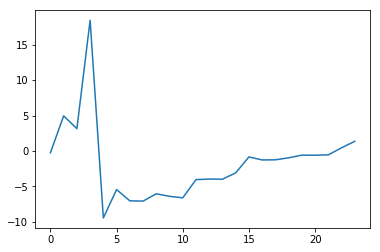

In [28]:
stats_sort = stats.sort_index()
plt.plot(stats_sort['mean'])

We can see that the delay increases from the beginning of the day after having falled violently during the night!

## 1.7 Arrival delay per week of day departure

In the same way, if we observe the arrival day based on day of departure:

In [29]:
df_tmp_copy['SCHEDULED_DEPARTURE_WEEK_OF_DAY'] = df_tmp_copy['SCHEDULED_DEPARTURE'].apply(lambda x: x.weekday())

In [30]:
df_tmp_copy['SCHEDULED_DEPARTURE_WEEK_OF_DAY'].unique()

array([1, 2, 3, 4, 5, 6, 0], dtype=int64)

In [31]:
df_tmp_copy = df_tmp.copy(deep=True)
df_tmp_copy['SCHEDULED_DEPARTURE'] = pd.to_datetime(df_tmp_copy['SCHEDULED_DEPARTURE'])
df_tmp_copy['SCHEDULED_DEPARTURE_WEEK_OF_DAY'] = df_tmp_copy['SCHEDULED_DEPARTURE'].apply(lambda x: x.weekday())
df_tmp_copy['ARRIVAL_DELAY_ORIGIN'] = invboxcox(df_tmp_copy['ARRIVAL_DELAY'], coxbox_ld_arrival_delay, coxbox_add_arrival_delay)
stats = df_tmp_copy['ARRIVAL_DELAY_ORIGIN'].groupby(df_tmp_copy['SCHEDULED_DEPARTURE_WEEK_OF_DAY']).apply(get_stats).unstack()
stats = stats.sort_values('mean', ascending=False)
stats

,count,max,mean,min
SCHEDULED_DEPARTURE_WEEK_OF_DAY,,,,
3,2834.0,86.0,0.294637,-56.0
4,2870.0,86.0,0.140070,-68.0
0,2888.0,85.0,-3.196330,-69.0
2,2846.0,86.0,-3.427266,-50.0
6,2706.0,86.0,-3.593126,-47.0
1,3051.0,86.0,-3.804654,-43.0
5,2383.0,86.0,-4.186320,-58.0


([<matplotlib.axis.XTick at 0x2410093e898>,
 <a list of 7 Text xticklabel objects>)

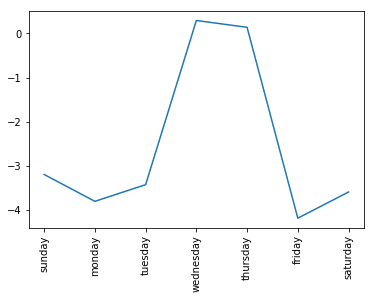

In [32]:
stats_sort = stats.sort_index()
plt.plot(stats_sort['mean'])
plt.xticks([0,1,2,3,4,5,6], ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday'], rotation='vertical')

The highest delay is on **friday** and on **monday**

## 1.8 Arrival delay based on origin airport

Let's observe arrival delay based on origin airport:

In [33]:
airlines = df_tmp['AIRLINE'].unique()
origin_airport_delays = pd.DataFrame(pd.Series(df_tmp['ORIGIN'].unique()))
origin_airport_delays.set_index(0, drop = True, inplace = True)

for airline in airlines:
    df1 = df_tmp[df_tmp['AIRLINE'] == airline]
    df1['ARRIVAL_DELAY_ORIGIN'] = invboxcox(df1['ARRIVAL_DELAY'], coxbox_ld_arrival_delay, coxbox_add_arrival_delay)
    test = df1['ARRIVAL_DELAY_ORIGIN'].groupby(df1['ORIGIN']).apply(get_stats)
    origin_airport_delays[airline] = test.loc[:, 'mean'] 

Text(0.5,0,'Delay in minutes')

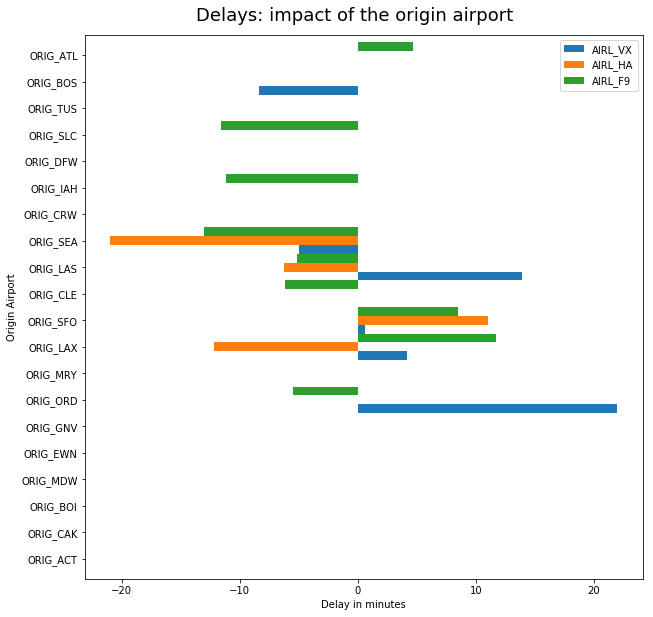

In [34]:
fig = plt.figure(1, figsize=(10,10))
fig.text(0.5, 0.9, "Delays: impact of the origin airport", ha='center', fontsize = 18)
subset = origin_airport_delays[['AIRL_VX','AIRL_HA','AIRL_F9']]
ax = fig.add_subplot(1,1,1)
subset[:20].plot(kind='barh', width=1, ax=ax)
ax.set_ylabel('Origin Airport')
ax.set_xlabel('Delay in minutes')

We can see that for airline **F9**, the mean delay from Atlanta (**ATL**), San Francisco (**SFO**) and Seattle (**SEA**) is not the same.

# 2. Compute our baseline

Let's compute our baseline based on pre-selected model:
- Linear Model: **Lasso**
- Optimised Feature selection: **SelectKBest**

In [35]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

In [36]:
from sklearn.metrics import make_scorer, mean_absolute_error

def mae(y_test, y_pred):
    y_test_ = invboxcox(y_test, coxbox_ld_arrival_delay, coxbox_add_arrival_delay)
    y_pred_ = invboxcox(y_pred, coxbox_ld_arrival_delay, coxbox_add_arrival_delay)
    y_pred_[np.isnan(y_pred_)] = 0
    return mean_absolute_error(y_pred_, y_test_)

mae_scorer = make_scorer(mae)

def lc_mae(model, X, y):
    y_pred = model.predict(X)
    return mae(y, y_pred)

In [37]:
df_tmp.shape

(19578, 644)

Let's select first **features** that we used for our baseline:

In [38]:
baseline_col = list(df_tmp.columns)
blacklist = ['AIRLINE',
 'ORIGIN',
 'DESTINATION',
 'SCHEDULED_DEPARTURE',
 'SCHEDULED_ARRIVAL']
baseline_col = [j for j in baseline_col if j not in blacklist]
df_tmp = df_tmp[baseline_col]

Let's then select **X** and **y** vectors to build then our train and test patterns:

In [39]:
X = df_tmp.as_matrix(np.concatenate([df_tmp.columns[:-2],[df_tmp.columns[-1]]]))
X = preprocessing.normalize(X)
y = df_tmp.as_matrix([df_tmp.columns[-2]])
y = y.flatten()

In [40]:
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X, y,
test_size=0.3, # 30% des données dans le jeu de test
random_state=10
)

In [41]:
pipeline = Pipeline([
        ('fs', SelectKBest(f_classif, k=300)), 
        ('lasso', Lasso(alpha = 1e-13))
])
gs_model = GridSearchCV(pipeline, {}, cv=5, n_jobs=1, 
                              verbose=1, scoring=mae_scorer)
gs_model.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('fs', SelectKBest(k=300, score_func=<function f_classif at 0x0000024107020AE8>)), ('lasso', Lasso(alpha=1e-13, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mae), verbose=1)

In [275]:
# Train and Test score
gs_model.cv_results_['mean_train_score'], gs_model.cv_results_['mean_test_score']

(array([ 12.94765762]), array([ 13.3529657]))

In [276]:
y_pred = gs_model.predict(X_test)
# Validation score
mae(y_pred, y_test)

13.146134835356154

We then have our baseline:
- **train_score** is equal to 12.95
- **test_score** is equal to 13.15

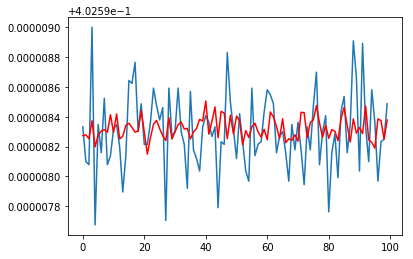

In [277]:
plt.plot(y_test[2000:2100])
plt.plot(y_pred[2000:2100], color='r')